# The Planar Manipulator

In [1]:
# python libraries
import mpld3
import numpy as np

from manipulation import running_as_notebook
from manipulation.exercises.pick.plot_planar_manipulator import plot_planar_manipulator

# enable mpld3 notebook
if running_as_notebook:
    mpld3.enable_notebook()

## Problem Description
In the lecture, we learned about forward and differential inverse kinematics. For this exercise, you will derive these equations for a simple two-link planar manipulator, using simple geometrical reasoning. As is the case with good toy problems, the two link manipulator has many insights that extend to the multi-link case, despite its apparent simplicity. 

**These are the main steps of the exercise:**
1. Write down the forward kinematics of the two-link manipulator. 
2. Derive the Jacobian of the forward kinematic map and analyze the conditions for which it is singular. 

# The Two-link Planar Manipulator 

The two-link planar manipulator is a very popular toy problem in manipulator kinematics and dynamics. The coordinate description of the two link manipulator can be seen in the below image:

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/planar_two_link.png" width="700">

In the [monogram notation](https://drake.mit.edu/doxygen_cxx/group__multibody__quantities.html) introduced in the textbook, the forward kinematics of the manipulator refers to writing down the 2D position of the red point in space with respect to the green frame, ${}^A p^C$, as a function of joint angles $(q_0,q_1)$. 

**Below, your job is to write down the forward kinematics of the manipulator. You may assume both arm lengths are equal, and their length is given by L=1.0m**

NOTE: You can use `np.sin()` and `np.cos()` for trigonometric implementations.

HINT: If you can write down the 2D position of the blue point with respect to the green frame, ${}^A p^B$ as a function of $q_0$, and the position of the red point with respect to the blue point, ${}^B p^C$ as a function of $q_1$, then can you write down what ${}^A p^C$ should be?

In [2]:
def rot_mat(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def rigid_trans_AB(theta_AB, p_AB):
    return np.array([
        [np.cos(theta_AB), -np.sin(theta_AB), p_AB[0, 0]],
        [np.sin(theta_AB), np.cos(theta_AB), p_AB[1, 0]],
        [0, 0, 1]
    ])

def X_AB_times_p_BC(X_AB, p_BC):
    return (X_AB @ np.vstack((p_BC, 1.0)))[:2]

def forward_kinematics(q):
    q0 = q[0]
    q1 = q[1]

    length = 1.0
    p_Jb2C = np.vstack([length, 0])
    p_Ja1B = np.vstack([length, 0])

    # kinematic tree - chain of transforms
    X_Jb2C = rigid_trans_AB(0, p_Jb2C)
    X_Jb1Jb2 = rigid_trans_AB(q1, np.zeros((3, 1)))
    X_Ja1Jb1 = rigid_trans_AB(0, p_Ja1B)
    X_AJa1 = rigid_trans_AB(q0, np.zeros((3, 1)))

    X_AC = X_AJa1 @ X_Ja1Jb1 @ X_Jb1Jb2 @ X_Jb2C
    
    p_CC = np.vstack([0, 0])
    p_AC = X_AB_times_p_BC(X_AC, p_CC)

    x = p_AC[0, 0]  # Fill your code here
    y = p_AC[1, 0]  # Fill your code here
    return np.array([x, y])

We've provided a function for you to plot the manipulator and an x-y position in 2D space, so that you can confirm that your reasoning is geometrically correct / debug any problems that occur.

Below, if the position of the x marker (your computed forward kinematics) coincides with the red marker (the actual end effector position), then your implementation should be correct. You can run it multiple times for different joint configurations.

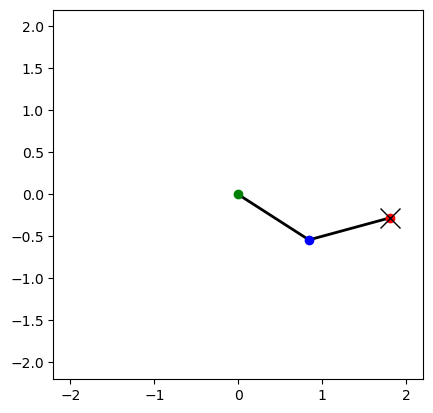

In [8]:
q = 2 * np.pi * np.random.rand(2)
plot_planar_manipulator(q, forward_kinematics(q))

## The Translational Jacobian 

Now that we have the forward kinematics function that gives us our end-effector position given the joint angles:
$${}^Ap^C=f(q),$$

Our job now is to derive the translational Jacobian of this simple manipulator. As observed in the lecture, the translational [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) is a matrix relating how a change in end-effector position is related to changes in joint angles: 

$$d {}^Ap^C=\frac{\partial f(q)}{\partial q} dq = \mathbf{J}(q) dq.$$

If you are not familiar with vector calculus, you can write it down even more explicitly as:

$$
\mathbf{J}(q)=\frac{\partial f(q)}{\partial q} = \begin{bmatrix} 
\partial x/\partial q_0 & \partial x/\partial q_1 \\ 
\partial y/\partial q_0 & \partial y/\partial q_1 \end{bmatrix}.
$$

We recommend you get familiar with these computations since they are super common for most robotic problems! 

**Below, you will write down the 2x2 Jacobian matrix based on the forward kinematics you have derived above.**

In [4]:
def Jacobian(q):
    q0 = q[0]
    q1 = q[1]

    # x = l1 * cos(q0) + l2 * cos(q0 + q1)
    # y = l1 * sin(q0) + l2 * sin(q0 + q1)
    l1, l2 = 1, 1

    px_pq0 = -l1 * np.sin(q0) - l2 * np.sin(q0 + q1)
    px_pq1 = -l2 * np.sin(q0 + q1)
    py_pq0 = l1 * np.cos(q0) + l2 * np.cos(q0 + q1)
    py_pq1 = l2 * np.cos(q0 + q1)

    J = np.array(
        [
            [px_pq0, px_pq1],  # Fill your code here.
            [py_pq0, py_pq1],
        ]  # Fill your code here.
    )
    return J

There is one insightful analysis we can do on this Jacobian - when can we invert the Jacobian to successfully recover joint velocities from end-effector velocities? From the textbook, we've seen we can analyze the **kinematic singularities** of the manipulator through the Jacobian - your job will be to explicitly reason about what they are. 

**What are the values of $(q_0,q_1)$ for which we cannot invert the Jacobian? (i.e. what are the kinematic singularities of this manipulator?)**

HINT: You should be able to identify two classes of configurations. 

NOTE: If you've correctly identified the answer, take a moment to connect this back to the error that we saw while running the telop example when the Kuka reached too far - do you see the fundamental source of this error now?  

## Your Answer

Submit your response to the question above in the Gradescope 'written submission' section!

Cannot invert J when it is not full row rank (2) which occurs when det(J) = 0.

Det(J) = (-l1 * np.sin(q0) - l2 * np.sin(q0 + q1))*l2 * np.cos(q0 + q1) + (l1 * np.cos(q0) + l2 * np.cos(q0 + q1))*l2 * np.sin(q0 + q1) = 0

This will happen when q1 = 0 or q1 = pi (or q1 = n*pi with n being any integer). In this case, end effector can't move radially



## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `planar_manipulator.ipynb` to Gradescope's notebook submission section, along with your notebook for the other problems.
- Copy and Paste your answer to the kinematic singularity problem to Gradescope's written submission section. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [2 pts] `forward_kinematics` must be implemented correctly. 
- [2 pts] `Jacobian` must be implemented correctly.
- [2 pts] You must answer correctly what the kinematic singularities are.

Below is our autograder where you can check the correctness of your implementation. 

In [5]:
from manipulation.exercises.grader import Grader
from manipulation.exercises.pick.test_planar_manipulator import TestPlanarManipulator

Grader.grade_output([TestPlanarManipulator], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 4/4.

Score for Test forward kinematics is 2/2.

Score for Test jacobian is 2/2.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3155e248-ad1e-4955-9626-599d4958faed' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>